# AEWS Python Notebook 08c: AEWS miscellanea

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: June 07, 2016 (slight update: July 15, 2016)

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

Building up on the concepts introduced in the previous notebooks in this series, we work out the remaining components of the AEWS implementation &mdash; see *'AEWS Python Notebook 08a'* for details of these components. The contents summary for the present notebook is given below.

**Abstract** &mdash; Though the WOFS data will ultimately be available as .netCDF dataset through the AGDC v2.0 API functions (just like the Landsat data), it is currently only accessible as tiles in .geoTiff files. This means that we need to potentially load the WOFS data from multiple files if a given lake / ROI spans multiple tiles. The notebook below (08c) provides code to achieve that. It also demonstrates some major issues when using WOFS data as an indicator of the lakes' extents, e.g. for the derivation of a "low-water" flag. These issues are summarised and discussed at the end of the notebook (basically indicating the need to use proper polygons for each lake instead).  
In the process, we also have to deal with (or rather, struggle with!) a specific issue with the current AGDC database where data queries return NBAR and PQ datasets with different numbers of available dates in them.

## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod 
```

**NOTE**: the specific module loaded here (`agdc-py2-prod`) is different from the module loaded in earlier notebooks (`agdc-py2-dev`)! While the earlier module contained only Landsat 5 data, the `agdc-py2-prod` module links to a (different) AGDC database containing the following NBART/NBAR/PQA datasets:

* Landsat 8: 2013
* Landsat 7: 2013
* Landsat 5: 2006/2007

It is unclear whether the API functions in these 2 modules are identical or represent different versions.

In [1]:
%%html  # Definitions for some pretty text boxes...
<style>
    div.warn { background-color: #e8c9c9; border-left: 5px solid #c27070; padding: 0.5em }
    div.note { background-color: #cce0ff; border-left: 5px solid #5c85d6; padding: 0.5em }
    div.info { background-color: #ffe680; border-left: 5px solid #cca300; padding: 0.5em }
</style>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ogr, gdal, osr
import json

from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Function: Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val'
    # and 'max_val', replacing 'nan_val' values with NumPy NaN's.
    f_arr = arr.astype('float') # required for NaN's
    if not np.isnan(nan_val): f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

def merge_dup_dates(xada):
    # Takes in an xarray.DataArray 'xada' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xada.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xada[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xada[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xada[dup_ind] = xada[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xada[dup_ind]) )
                    xada[dup_ind].values[tmp] = xada[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xada[ind]) )
                    xada[ind].values[tmp] = xada[dup_ind].values[tmp]
                    xada[dup_ind] = xada[ind]   # save results to lowest date index, in case >2 slices have same date
    return xada[~rem_ind]

## Select ROI from shape file

Let's select a ROI from the `.shp` file of lakes extents provided by DPI Water. We'll try and see if there exists a ROI spanning multiple WOFS tiles.

In [3]:
env_file = '../NSW_lakes/NSW_Lakes_envelope.shp'
env_vec = ogr.Open(env_file)
env_lyr = env_vec.GetLayer(0)
n_ftr = env_lyr.GetFeatureCount()

ftr_coords = np.ones((n_ftr,4)) * np.nan   # save min/max coords of all features
lname_list = list()
ltype_list = list()

print( "Lat/lon extents for features spanning multiple WOFS tiles:\n")
for kk in range( n_ftr ):
    ftr = env_lyr.GetFeature(kk)
    ftr_json = json.loads(ftr.ExportToJson())
    coords = np.array( ftr_json['geometry']['coordinates'][0] )
    min_lat = min(coords[:,1]); ftr_coords[kk,0] = min_lat
    max_lat = max(coords[:,1]); ftr_coords[kk,1] = max_lat
    min_lon = min(coords[:,0]); ftr_coords[kk,2] = min_lon
    max_lon = max(coords[:,0]); ftr_coords[kk,3] = max_lon
    
    lake_name = ftr_json['properties']['HYDRONAME']; lname_list.append(lake_name)
    lake_type = ftr_json['properties']['HYDRONAMET']; ltype_list.append(lake_type)
    lake_nr = ftr_json['properties']['HYDRONAMEO']
    
    tmp1 = np.floor(max_lon)!=np.floor(min_lon)
    tmp2 = np.floor(max_lat)!=np.floor(min_lat)
    if ( tmp1 or tmp2 ):
        print( "  Feat. {}:".format(kk), lake_type, lake_name, "({}):".format(lake_nr),
               "lat. {}...{} / lon. {}...{}".format(min_lat,max_lat,min_lon,max_lon) )
        A = (max_lat-min_lat) * (max_lon-min_lon)   # some measure of lake size...
        if ( tmp1 and tmp2 ): 
            print("             ... spanning >=4 WOFS tiles (",A,")")
        else:
            print("             ... spanning 2 WOFS tiles (",A,")")

Lat/lon extents for features spanning multiple WOFS tiles:

  Feat. 19: LAKE NETTLEGOE (7452): lat. -32.541258698...-32.4980596838 / lon. 141.959169986...142.005269045
             ... spanning 2 WOFS tiles ( 0.00199143389796 )
  Feat. 62: LAKE STARVATION (9342): lat. -30.4678210874...-30.4189063977 / lon. 140.989065361...141.011109966
             ... spanning 2 WOFS tiles ( 0.00107830499175 )
  Feat. 78: LAKES PRUNGLE (8257): lat. -34.2117050268...-34.1870599538 / lon. 142.996299454...143.015187752
             ... spanning 2 WOFS tiles ( 0.000465503474056 )
  Feat. 114: LAKES CHIBNALWOOD (2220): lat. -33.9052720679...-33.847028914 / lon. 142.995237169...143.052091282
             ... spanning 2 WOFS tiles ( 0.00331136288403 )
  Feat. 144: LAKE COOMBAH (2610): lat. -33.0248727312...-32.9174035596 / lon. 141.600811713...141.645696171
             ... spanning 2 WOFS tiles ( 0.00482369546904 )
  Feat. 203: LAKE WHITE (10715): lat. -33.0188158597...-32.9862466286 / lon. 141.447488343...

So we have a number of features (lakes) spanning two WOFS tiles, but none of them are actually across four (or more) tiles.

## Loading some LS8 data

Let's now check for available time slices for one of the largest lakes... (**Note**: after some investigations, it was found that this dataset has a missing date of PQ data on 2013-10-01, with the discrepancy leading to issues in subsequent processing; thus we are here only using the 2013 data up to, and not including that date).  
<br>
<div class=warn>
<b>TO DO:</b> we will need a strategy to deal with discrepancies in available NBAR and PQ time slices $-$ one possibility would be to do our own processing for cloud and shadow masking.
</div>

In [4]:
dc = datacube.api.API()

In [5]:
ftr = 343
dimensions = { 'lon' : { 'range': (ftr_coords[ftr,2], ftr_coords[ftr,3]) },
               'lat' : { 'range': (ftr_coords[ftr,1], ftr_coords[ftr,0]) },
               'time': { 'range': ((2013, 1, 1), (2013, 10, 1)) } }
query = { 'product': 'nbar',
          'platform': 'LANDSAT_8',
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)
print( "Nr. available dates:", desc['ls8_nbar_albers']['result_shape'][0])

Nr. available dates: 75


In [6]:
# ## This code can be used to check the consistency of NBAR and PQ dates with the current AGDC database
# dims = { 'lon' : { 'range': (ftr_coords[ftr,2], ftr_coords[ftr,3]) },
#          'lat' : { 'range': (ftr_coords[ftr,1], ftr_coords[ftr,0]) },
#          'time': { 'range': ((2013, 1, 1), (2014, 1, 1)) } }
#
# query = { 'product': 'nbar',
#           'platform': 'LANDSAT_8',
#           'dimensions': dims }
# desc = dc.get_descriptor(query, include_storage_units=False)
# print( "Nr. available NBAR dates:", desc['ls8_nbar_albers']['result_shape'][0])
#
# query = { 'product': 'pqa',
#           'platform': 'LANDSAT_8',
#           'dimensions': dims }
# Pdesc = dc.get_descriptor(query, include_storage_units=False)
# print( "Nr. available PQ dates:", Pdesc['ls8_pq_albers']['result_shape'][0])
#
# tmp1 = set(desc['ls8_nbar_albers']['irregular_indices']['time'])
# tmp2 = set(Pdesc['ls8_pq_albers']['irregular_indices']['time'])
# print( "Missing dates are:\n", list(tmp1-tmp2))

In [7]:
# ## This code used for quick visual inspection of lake levels...
# ae = AnalyticsEngine(); ee = ExecutionEngine()
# aeB5 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_6'], dimensions, 'aeB5')
# ee.execute_plan(ae.plan)
#
# B5_xarray = ee.cache['aeB5']['array_result'].values()[0]  # 'band_6' ...!
# B5_xarray = merge_dup_dates( B5_xarray.load() )
# print( "Nr. available dates:", B5_xarray.shape[0])
#
# tmp = np.where( ( (~np.isnan(B5_xarray)).sum('x').sum('y')!=0 ).values )[0]
# B5_xarray = B5_xarray[tmp]
# print( "Nr. available dates:", B5_xarray.shape[0])
#
# B5_xarray.plot(row='time');   # search for plots with min(B5)<100 ...

So we have available Landsat 8 data for that feature in 2013, which spans 2 WOFS tiles. Let's load that data for subsequent processing / plotting.

In [8]:
ae = AnalyticsEngine(); ee = ExecutionEngine()
aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'aeB3')
aeB4 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_5'], dimensions, 'aeB4')
aeB5 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_6'], dimensions, 'aeB5')
aeB7 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_7'], dimensions, 'aeB7')   # SWIR2 band
aePQ = ae.create_array(('LANDSAT_8', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
aeWQ_PQmsk = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_PQmsk')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [9]:
# Merge datasets with duplicated dates:
B2_xarray = ee.cache['aeB2']['array_result'].values()[0]  # 'band_3' ...!
B2_xarray = merge_dup_dates( B2_xarray.load() )
B3_xarray = ee.cache['aeB3']['array_result'].values()[0]  # 'band_4' ...!
B3_xarray = merge_dup_dates( B3_xarray.load() )
B4_xarray = ee.cache['aeB4']['array_result'].values()[0]  # 'band_5' ...!
B4_xarray = merge_dup_dates( B4_xarray.load() )
B5_xarray = ee.cache['aeB5']['array_result'].values()[0]  # 'band_6' ...!
B5_xarray = merge_dup_dates( B5_xarray.load() )
B7_xarray = ee.cache['aeB7']['array_result'].values()[0]  # 'band_7' ...!
B7_xarray = merge_dup_dates( B7_xarray.load() )
WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
WQ_xarray = merge_dup_dates( WQ_xarray.load() )
WQ_pqm_xarray = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk']
WQ_pqm_xarray = merge_dup_dates( WQ_pqm_xarray.load() )
print( "Nr. available dates:", B2_xarray.shape[0])

Nr. available dates: 32


In [10]:
# Remove time slices with only NaN pixels:
valid_indx = np.where( ( (~np.isnan(B2_xarray)).sum('x').sum('y')!=0 ).values )[0] 
B2_xarray = B2_xarray[valid_indx]
tmp = np.where( ( (~np.isnan(B3_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B3: Valid dates discrepancy found!" )   # should be identical between bands!...
B3_xarray = B3_xarray[tmp]
tmp = np.where( ( (~np.isnan(B4_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B4: Valid dates discrepancy found!" )
B4_xarray = B4_xarray[tmp]
tmp = np.where( ( (~np.isnan(B5_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B5: Valid dates discrepancy found!" )
B5_xarray = B5_xarray[tmp]
tmp = np.where( ( (~np.isnan(B7_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "B7: Valid dates discrepancy found!" )
B7_xarray = B7_xarray[tmp]
tmp = np.where( ( (~np.isnan(WQ_xarray)).sum('x').sum('y')!=0 ).values )[0]
if not (valid_indx==tmp).all(): print( "WQ: Valid dates discrepancy found!" )
WQ_xarray = WQ_xarray[tmp]
tmp = np.where( ( (~np.isnan(WQ_pqm_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ_pqm_xarray = WQ_pqm_xarray[tmp]   # more dates could need removing due to cloud masking
print( "Nr. available dates:", B2_xarray.shape[0])

Nr. available dates: 20


Some visual candy...

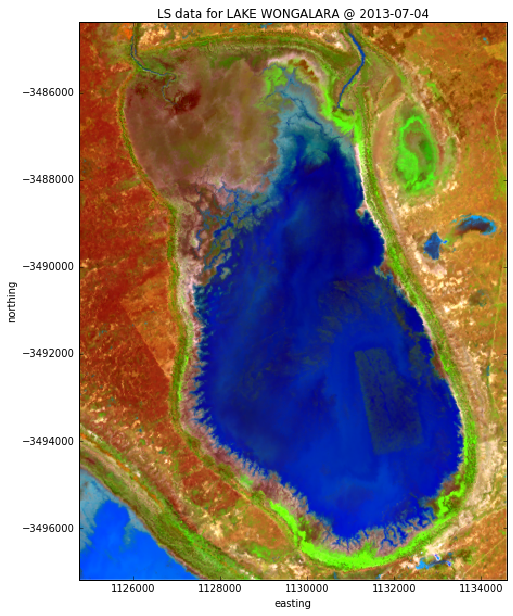

In [11]:
date_ind = 8   # selected date index
sB2data = scale_array(B2_xarray[date_ind].values, 99.0, 0, 255, np.nan)
sB4data = scale_array(B4_xarray[date_ind].values, 99.0, 0, 255, np.nan)
sB5data = scale_array(B5_xarray[date_ind].values, 99.0, 0, 255, np.nan)
FC_image = np.zeros((B2_xarray.shape[1], B2_xarray.shape[2], 3), dtype='uint8')
FC_image[:,:,0] = sB5data; FC_image[:,:,1] = sB4data; FC_image[:,:,2] = sB2data

xvec = B2_xarray.coords['x']; yvec = B2_xarray.coords['y']
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
tmp = str(B2_xarray.coords['time'][date_ind].values)[:10]
plt.title( 'LS data for {} {} @ {}'.format(ltype_list[ftr], lname_list[ftr], tmp) )
plt.ylabel('northing'); plt.xlabel('easting');

A significant section of the northern part of this lake appears dry, so it looks like this could be a good candidate waterbody to test the difference between the SWIR filter output and the WOFS water mask...

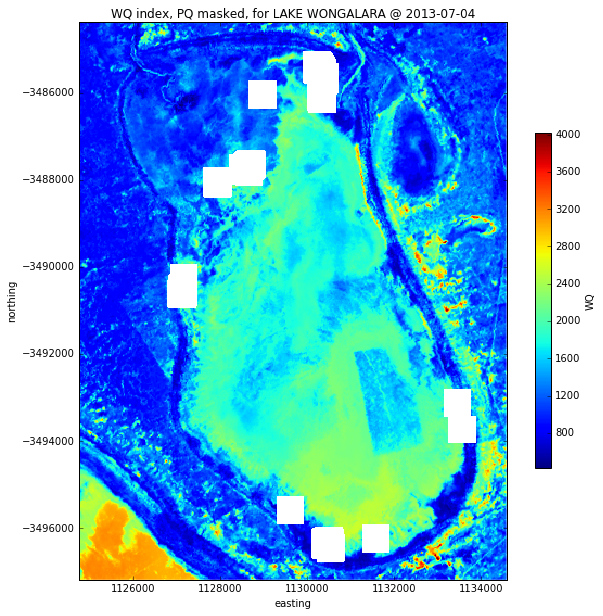

In [12]:
pq_ind = 5   # in the PQ masked dataset, some of the original dates ended up with NaNs everywhere due to clouds, 
             # and were thus removed from the 'time series'; we thus have to select a different index here.
plt.imshow( WQ_pqm_xarray[pq_ind], interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
pq_datestr = str(WQ_pqm_xarray.coords['time'][pq_ind].values)[:10]
plt.title( 'WQ index, PQ masked, for {} {} @ {}'.format(ltype_list[ftr], lname_list[ftr], pq_datestr) )
plt.ylabel('northing'); plt.xlabel('easting')
plt.colorbar(orientation='vertical', shrink=0.6, label='WQ');

## Loading WOFS data over multiple tiles

Let's write some code that automatically deals with the multiple tiles. We'll assume here that the required WOFS dataset only ever spans two tiles at most (the code thus will need uptading if we want it to handle lakes spanning more than 2 tiles).

In [13]:
base_folder = '/g/data2/fk4/wofs/current/pyramids/WaterSummary/0/'   # where geoTiff WOFS data is located

min_lat, max_lat, min_lon, max_lon = ftr_coords[ftr,:]

adj_tile_lon = np.floor(max_lon)!=np.floor(min_lon)  # two adjacent 'horizontal' WOFS tiles
adj_tile_lat = np.floor(max_lat)!=np.floor(min_lat)  # two adjacent 'vertical' WOFS tiles

if ( adj_tile_lat and adj_tile_lon ):
    raise NotImplementedError("Dataset spans 3 or more WOFS tiles.")

# Load the first (top-left) of (potentially) two WOFS tiles:
WOFS_fname = base_folder + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( np.floor(min_lon), np.floor(max_lat) )
WOFS_dataset = gdal.Open(WOFS_fname)
WOFS_array = WOFS_dataset.ReadAsArray()
WOFS_geotx = list( WOFS_dataset.GetGeoTransform() )
WOFS_proj = WOFS_dataset.GetProjection()   # geodetic lat/lon
WOFS_srs = osr.SpatialReference( wkt=WOFS_proj )
WOFS_lonvec = np.arange(WOFS_array.shape[0]) * WOFS_geotx[1] + WOFS_geotx[0]
WOFS_latvec = np.arange(WOFS_array.shape[1]) * WOFS_geotx[5] + WOFS_geotx[3]

if ( adj_tile_lon ):   # if two horizontal tiles
    WOFS_fname = base_folder + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( np.floor(max_lon), np.floor(max_lat) )
    WOFS_dataset = gdal.Open(WOFS_fname)
    wa2 = WOFS_dataset.ReadAsArray()
    wg2 = list( WOFS_dataset.GetGeoTransform() )
    WOFS_lonvec = np.concatenate(( WOFS_lonvec, np.arange(wa2.shape[0]) * wg2[1] + wg2[0] ),0)
    WOFS_array = np.concatenate((WOFS_array,wa2),1)   # column bind
elif ( adj_tile_lat ):   # if two vertical tiles
    WOFS_fname = base_folder + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( np.floor(min_lon), np.floor(min_lat) )
    WOFS_dataset = gdal.Open(WOFS_fname)
    wa2 = WOFS_dataset.ReadAsArray()
    wg2 = list( WOFS_dataset.GetGeoTransform() )
    WOFS_latvec = np.concatenate(( WOFS_latvec, np.arange(wa2.shape[1]) * wg2[5] + wg2[3] ),0)
    WOFS_array = np.concatenate((WOFS_array,wa2),0)   # row bind

In [14]:
# Extract WOFS over region of interest:
yind_min = np.where( WOFS_lonvec>=dimensions['lon']['range'][0] )[0][0]
yind_max = np.where( WOFS_lonvec<=dimensions['lon']['range'][1] )[0][-1]
WOFS_lonvec = WOFS_lonvec[yind_min:yind_max+1]

xind_max = np.where( WOFS_latvec>=dimensions['lat']['range'][1] )[0][-1]
xind_min = np.where( WOFS_latvec<=dimensions['lat']['range'][0] )[0][0]
WOFS_latvec = WOFS_latvec[xind_min:xind_max+1]

WOFS_array = WOFS_array[xind_min:xind_max+1, yind_min:yind_max+1]
WOFS_geotx[0] = WOFS_geotx[0] + yind_min*WOFS_geotx[1]
WOFS_geotx[3] = WOFS_geotx[3] + xind_min*WOFS_geotx[5]

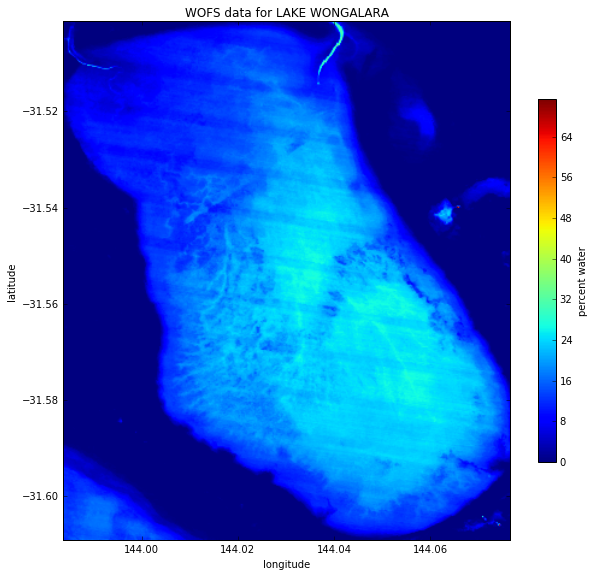

In [15]:
plt.imshow(WOFS_array, extent=[WOFS_lonvec[0],WOFS_lonvec[-1],WOFS_latvec[-1],WOFS_latvec[0]])
plt.title( 'WOFS data for {} {}'.format(ltype_list[ftr], lname_list[ftr]) )
plt.xlabel('longitude'); plt.ylabel('latitude')
plt.colorbar(orientation='vertical', shrink=0.65, label='percent water');

OK, so we do indeed have a lake that's partly empty on average (water for a maximum of about 25% of the time / WOFS observations). This however raises the question of what to do when the WOFS 90% mask indicates that there is no water, but the lake is still of interest to DPI Water...  
<br>
<div class=note>
<b>NOTE:</b> the WOFS data isn't as good an indicator of lake boundaries as originally thought.
</div>

One way to address this would be to use a much lower water percentage threshold to get the water's edge more generally, and hope that the SWIR filter will further discard the low-water pixels.

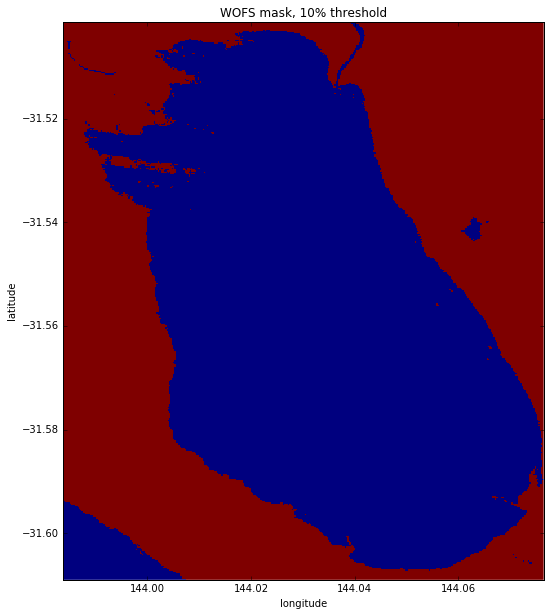

In [16]:
WOFS_mask_wide = ( WOFS_array<10.0 )

plt.imshow(WOFS_mask_wide, interpolation='none', 
           extent=[WOFS_lonvec[0],WOFS_lonvec[-1],WOFS_latvec[-1],WOFS_latvec[0]], aspect=1)
plt.title( 'WOFS mask, 10% threshold' )
plt.ylabel('latitude'); plt.xlabel('longitude');

We now have a semi-decent mask of the lake's extent, though somehwat noisy. Also, this includes other water "features" such as rivers, which might not be ideal. It also includes other neighbouring waterbodies not being the focus of the present analysis. Lastly, it is unclear whether this approach would be universally successful across all available lakes and waterbodies in NSW.

## Reprojecting LS data

We need to reproject the LS8 data to geodetic, to match the WOFS dataset. For simplicity, we'll only use the WQ data for one date from here on...

In [17]:
query = { 'product': 'nbar',
          'platform': 'LANDSAT_8',
          'dimensions': dimensions }
LS_data = dc.get_data( query )
LS_proj_str = LS_data['coordinate_reference_systems'][1]['reference_system_definition']
LS_proj = osr.SpatialReference( wkt=LS_proj_str )   # will hopefully be part of the ee.cache results at some stage

LSxvec = WQ_pqm_xarray['x'].values; LSyvec = WQ_pqm_xarray['y'].values
LSpix_size = np.mean(LSxvec[1:] - LSxvec[:-1])
LS_geotx = ( LSxvec[0], LSpix_size, 0, LSyvec[0], 0, -LSpix_size )

# WQ gdal dataset
tmp, WQ_dx, WQ_dy = WQ_pqm_xarray.shape
gdal_data = gdal.GetDriverByName( 'MEM' ).Create('', WQ_dy, WQ_dx, 1, gdal.GDT_Float32)
gdal_data.SetGeoTransform( LS_geotx )
gdal_data.SetProjection( LS_proj.ExportToWkt() )
gdal_data.GetRasterBand(1).WriteArray( WQ_pqm_xarray[pq_ind].values, 0, 0)

# Reprojection variables
WOFS_dx, WOFS_dy = WOFS_array.shape
gdalgeo_data = gdal.GetDriverByName( 'MEM' ).Create('', WOFS_dy, WOFS_dx, 1, gdal.GDT_Float32)
gdalgeo_data.SetGeoTransform( WOFS_geotx )
gdalgeo_data.SetProjection( WOFS_proj )

# Reprojecting the WQ gdal dataset to match the WOFS coordinates:
gdalgeo_data.GetRasterBand(1).WriteArray( np.ones((WOFS_dx,WOFS_dy))*np.nan, 0, 0)
res = gdal.ReprojectImage( gdal_data, gdalgeo_data,
                           LS_proj.ExportToWkt(), WOFS_proj,
                           gdal.GRA_Bilinear )   # gdal.GRA_NearestNeighbour by default
WQ_array = gdalgeo_data.ReadAsArray()   # reprojected result

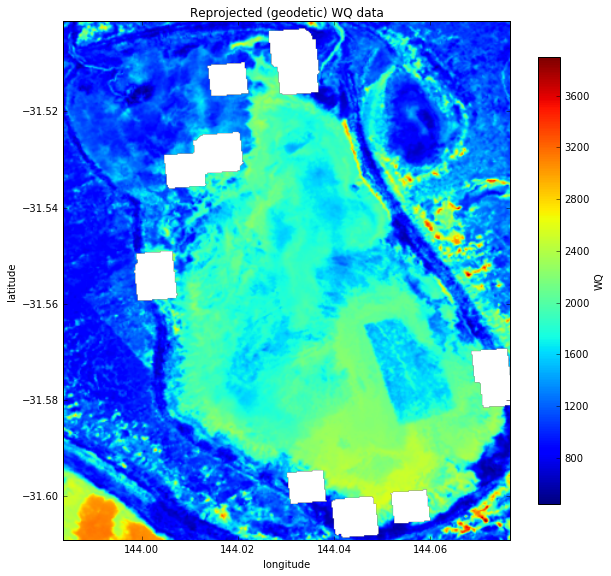

In [18]:
plt.imshow(WQ_array, extent=[WOFS_lonvec[0],WOFS_lonvec[-1],WOFS_latvec[-1],WOFS_latvec[0]])
plt.title('Reprojected (geodetic) WQ data')
plt.ylabel('latitude'); plt.xlabel('longitude');
plt.colorbar(orientation='vertical', shrink=0.8, label='WQ');

We also need to reproject the LS8 Band 7 data to be able to generate the SWIR filter mask.

In [19]:
gdal_data.GetRasterBand(1).WriteArray( B7_xarray[date_ind].values, 0, 0)

gdalgeo_data.GetRasterBand(1).WriteArray( np.ones((WOFS_dx,WOFS_dy))*np.nan, 0, 0)
res = gdal.ReprojectImage( gdal_data, gdalgeo_data,
                           LS_proj.ExportToWkt(), WOFS_proj,
                           gdal.GRA_Bilinear )   # gdal.GRA_NearestNeighbour by default
B7_array = gdalgeo_data.ReadAsArray()   # reprojected result

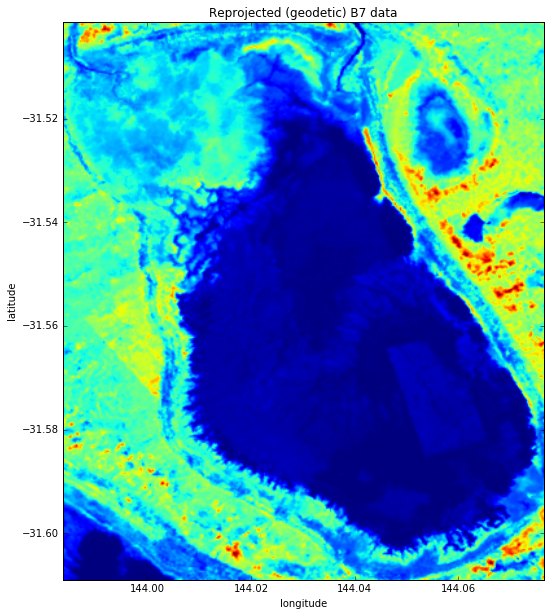

In [20]:
plt.imshow(B7_array, extent=[WOFS_lonvec[0],WOFS_lonvec[-1],WOFS_latvec[-1],WOFS_latvec[0]])
plt.title('Reprojected (geodetic) B7 data')
plt.ylabel('latitude'); plt.xlabel('longitude');

## SWIR filter

As per the previous notebook _"AEWS Python Notebook 08b"_, we can now create the SWIR filter mask from the LS8 band 7 data, and apply it to the WQ data:

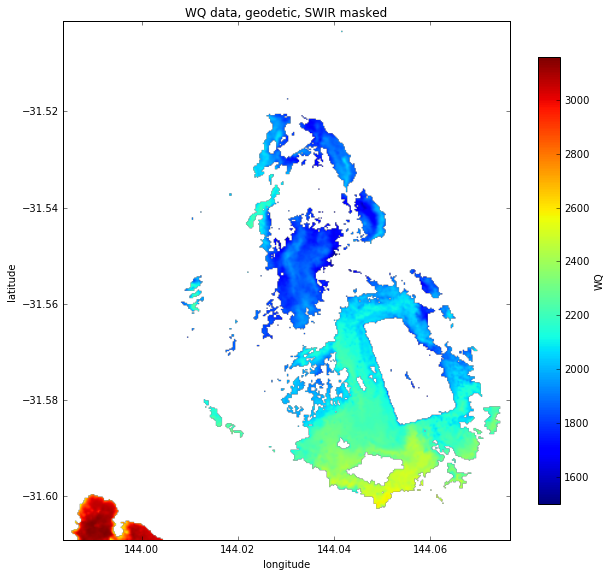

In [21]:
SWIR_mask = ( B7_array>100 )

WQ_array_SWIRmsk = WQ_array.copy()
WQ_array_SWIRmsk[SWIR_mask] = np.nan

plt.imshow(WQ_array_SWIRmsk, extent=[WOFS_lonvec[0],WOFS_lonvec[-1],WOFS_latvec[-1],WOFS_latvec[0]])
plt.title('WQ data, geodetic, SWIR masked')
plt.ylabel('latitude'); plt.xlabel('longitude');
plt.colorbar(orientation='vertical', shrink=0.8, label='WQ');

As expected, a lot of the lake has been masked out by the SWIR mask due to shallow waters. This result however also highlights an issue with using WOFS and SWIR data to identify lake boundaries: other water areas not part of the lake of interest (as shown in the plot above in the bottom-left corner) might still come through as being part of the dataset of interest. 

The best workaround for this issue would be to use the shape file provided by DPI Water containing the polygons for the lakes of interest. A mask could then be created to only select the relevant pixels for that lake only.

As expected, a further filtering with the WOFS mask with 10% threshold does not provide any improvement:

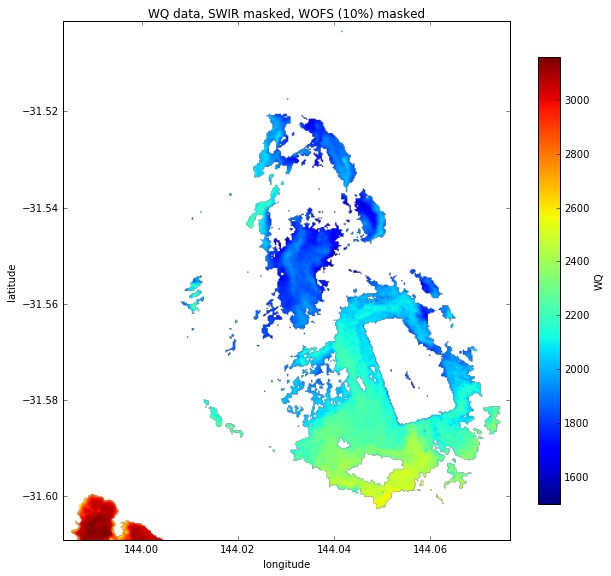

In [22]:
WQ_array_SWIRmsk_WOFSmsk = WQ_array_SWIRmsk.copy()
WQ_array_SWIRmsk_WOFSmsk[WOFS_mask_wide] = np.nan

plt.imshow(WQ_array_SWIRmsk_WOFSmsk, extent=[WOFS_lonvec[0],WOFS_lonvec[-1],WOFS_latvec[-1],WOFS_latvec[0]])
plt.title('WQ data, SWIR masked, WOFS (10%) masked')
plt.ylabel('latitude'); plt.xlabel('longitude');
plt.colorbar(orientation='vertical', shrink=0.8, label='WQ');

## Recap

This notebook investigated the issues of WOFS masking when a lake spans multiple WOFS tiles, and identification of a "low water" flag (through comparison of WOFS and SWIR masks) that could be used to highlight lakes that may be drying up.

A number of issues were identified in the process. These can be summarised as follows:

1. Certain lakes of interest to DPI Water appear to be "ephemeral" waterbodies, in the sense that the WOFS data indicate a low percentage of water observations (<90%) over those waterbodies. This in turn implies that, in such instances:  

    1. the WOFS 90% mask cannot be used to identify the lake boundaries
    - comparison between the WOFS and SWIR masks cannot be carried out, unless a much lower WOFS threshold (e.g. 10%) is used
    - a "low water" flag would be meaningless given that the WOFS 90% data does not indicate the consistent presence of water 

- The use of WOFS and SWIR masks does not ensure the selection of only one waterbody of interest in the ROI (lat/lon extents); the example above show that two different yet sizeable lakes could be present within the same ROI, with both of them (or parts thereof) "coming through" the SWIR and WOFS masks (when only one of them is of interest)

Some strategies could be found to try and partly address these problems. For instance, a flood-filling algorithm could be implemented on the WOFS masks to enumerate the main waterbodies in the ROI and discard those of no interest (e.g. smaller). This approach, however, would require the lake of interest to be somehow identified within the ROI, e.g. using the coordinates of its main body, etc.  
<br>
<div class=warn>
<b>TO DO:</b> we need another dataset rather than WOFS for a proper derivation of the lakes' extents.
</div>

Probably the most relevant solution would be to use the lakes' polygons directly, if available. This would enable the calculation of a lake-specific mask of "assumed lake boundary", which could then be used to compare against the SWIR mask to generate the low-water flag. This would thus alleviate the above issues 1A, 1B, 1C, and 2.

This approach (lakes' polygons) could of course also be used to further refine the WOFS mask, i.e. selecting only the WOFS data over the lake of interest. However, even if some of this updated WOFS mask is above 90%, it could still not be used as an indication of the lake's extent (e.g. if a large portion of the lake is "ephemeral"): the water's extent on a given date could still be larger or smaller than the WOFS 90% line, thus not necessarily indicating that the lake level is low or high. In terms of using WOFS, this "polygon-updated" WOFS mask could thus only be used to infer the following:

- if none of the updated WOFS mask is above 90%, this would indicate some kind of ephemeral waterbody (regardless of the current water contend as provided by the SWIR filter)
- if some of the updated WOFS mask is above 90%, then the SWIR water extent can only provide an indication of whether the lake's level is **lower or higher than its _long-term average level_** (as provided by WOFS).

<br>
<div class=note>
<b>NOTE:</b> it turns out that the WOFS data is only of limited use within the AEWS framework.
</div>
